In [1]:
import numpy as np 
import pandas as pd
import math
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def import_data():
 data = pd.read_csv('norway_new_car_sales_by_make.csv')
 
 data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
 
 df = pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
 return df

In [3]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 loops = periods + 1- x_len- y_len
 train = []
 for col in range(loops):
    train.append(D[:,col:col+x_len+y_len])
 
 train = np.vstack(train)
 print(train.shape)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)

    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
 return X_train, Y_train, X_test, Y_test

In [4]:
df = import_data()


In [5]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
 df = pd.DataFrame(columns = ['MAE','RMSE','Bias'],index=['Train','Test'])
 df.index.name = name
 
 df.loc['Train','MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)

 df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
 
 df.loc['Train','Bias'] = 100*np.mean((Y_train- Y_train_pred))/np.mean(Y_train)

 df.loc['Test','MAE'] = 100*np.mean(abs(Y_test- Y_test_pred))/np.mean(Y_test)
 
 df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
 
 df.loc['Test','Bias'] = 100*np.mean((Y_test- Y_test_pred))/np.mean(Y_test)
 df = df.astype(float).round(1) #Round number for display
 print(df)

In [6]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=12)
mdl = LinearRegression()
mdl.fit(X_train,Y_train)
y_tr = mdl.predict(X_train)
y_te = mdl.predict(X_test)
kpi_ML(Y_train,y_tr,Y_test,y_te,'Regression')

(7085, 13)
             MAE  RMSE  Bias
Regression                  
Train       17.8  43.9   0.0
Test        17.8  43.7   1.6


In [7]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=0)
reg = LinearRegression()
reg = reg.fit(X_train,Y_train)
forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index)
print(forecast)

(7085, 13)
                        0
Make                     
Alfa Romeo       6.187217
Aston Martin     1.032483
Audi           646.568622
BMW           1265.032834
Bentley          1.218092
...                   ...
Think            1.136894
Toyota        1457.084869
Volkswagen    1936.969437
Volvo          929.180180
Westfield        1.136894

[65 rows x 1 columns]


In [8]:
from sklearn.tree import DecisionTreeRegressor
# Instantiate a Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=4)
# Fit the tree to the training data
tree.fit(X_train,Y_train)
y_tr = tree.predict(X_train)
y_te = tree.predict(X_test)
kpi_ML(Y_train,y_tr,Y_test,y_te,'Regression tree')

                  MAE  RMSE  Bias
Regression tree                  
Train            16.6  40.1   0.0
Test              NaN   NaN   NaN


In [9]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=0)
reg = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=4)
reg = reg.fit(X_train,Y_train)
forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index)
print(forecast)

(7085, 13)
                        0
Make                     
Alfa Romeo       5.784483
Aston Martin     0.229475
Audi           558.170330
BMW           1569.750000
Bentley          0.229475
...                   ...
Think            0.229475
Toyota        1691.823529
Volkswagen    2157.416667
Volvo          837.090909
Westfield        0.229475

[65 rows x 1 columns]


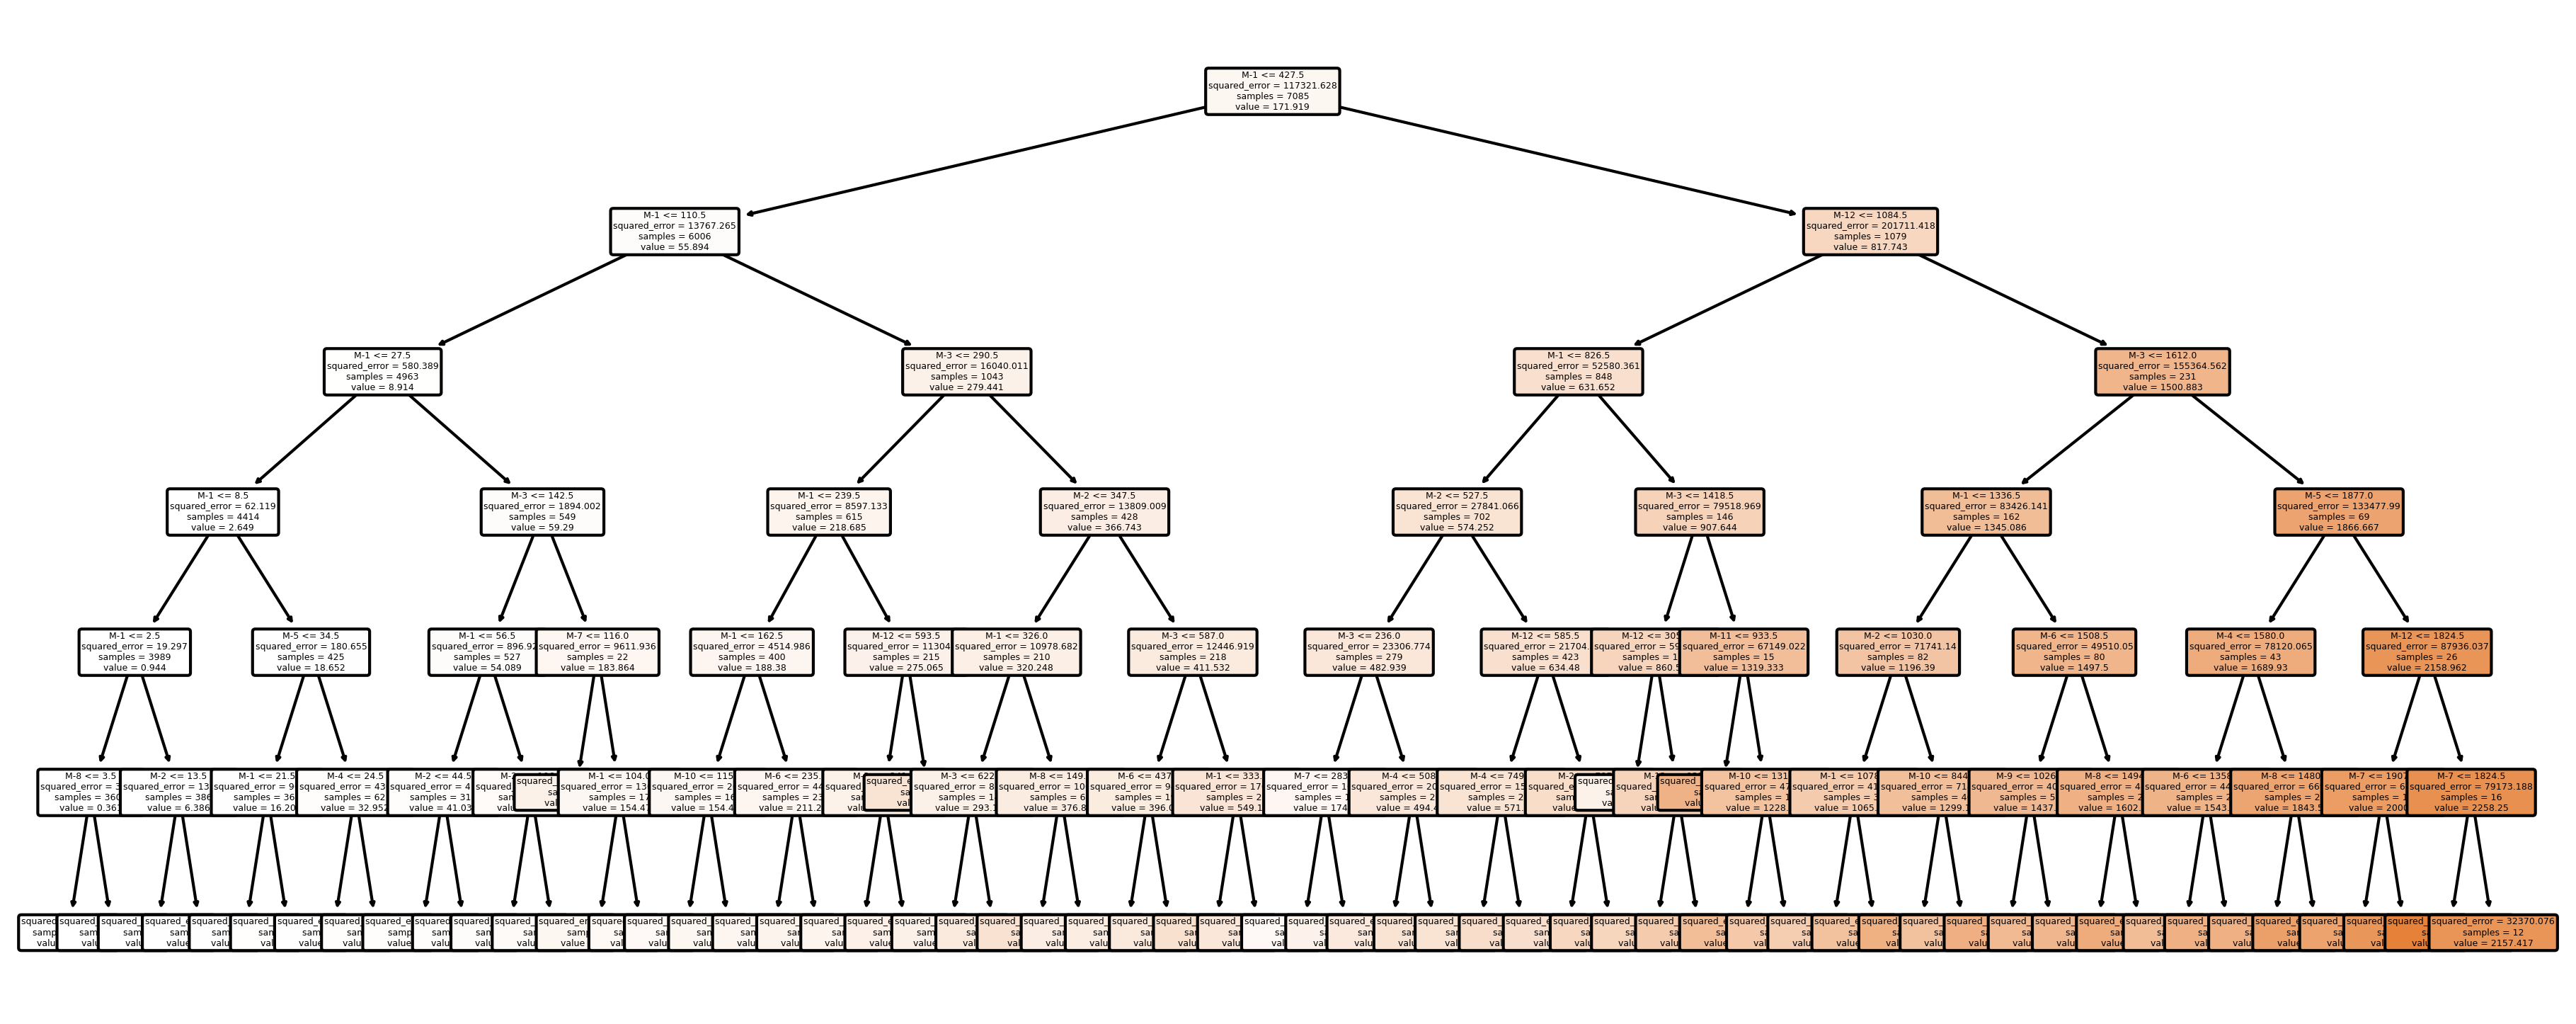

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(tree, fontsize=3, feature_names=[f'M{x-12}' for x in range(12)], rounded=True, filled=True, ax=ax)
fig.savefig('Regression Tree.PNG')

In [17]:
#Optimizing with diff errors
import time
for criterion in ['squared_error','absolute_error']:
 start_time = time.time()
 tree = DecisionTreeRegressor(max_depth=7, min_samples_split=19, min_samples_leaf=13, criterion=criterion)
 tree.fit(X_train,Y_train)
 Y_train_pred = tree.predict(X_train)
 Y_test_pred = tree.predict(X_test)
 kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=f'Tree {criterion}')
 print('{:0.2f} seconds'.format(time.time()- start_time))
 print()

                     MAE  RMSE  Bias
Tree squared_error                  
Train               16.4  40.2  -0.0
Test                 NaN   NaN   NaN
0.11 seconds

                      MAE  RMSE  Bias
Tree absolute_error                  
Train                15.5  41.6   1.7
Test                  NaN   NaN   NaN
2.05 seconds



In [19]:
#Finding best parameters(Parameter tuning)

max_depth = list(range(2,15))+[None]
min_samples_split = range(2,20)
min_samples_leaf = range(2,20)
params = {'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeRegressor()
treecv = RandomizedSearchCV(tree,params,n_iter=80, n_jobs=-1,verbose=1,cv=5,scoring='neg_mean_absolute_error')
treecv.fit(X_train,Y_train)
treecv.best_params_
Y_train_pred = treecv.predict(X_train)
Y_test_pred = treecv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
        MAE  RMSE  Bias
Tree                   
Train  15.9  38.5   0.0
Test    NaN   NaN   NaN
